# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination

# Imports

In [1]:
import os
import sys
from IPython.display import display

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

# Globals

In [2]:
N_THREADS = 16
IDENTITY_THRESHOLD=70

LOG_FILE = "../logs/meta_amino_sugar.log"
N_THREADS = 16
ORGANISM = "meta"

# Dataset

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass
# e coli, a thaliana, human
create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    outliers=["P76773", "Q47706", "P64550", "P02943", "P75733", "P69856"]
    + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
    + ["Q9HBR0", "Q07837"],
    tax_ids_filter=[3702, 9606, 83333, 559292],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
...,...,...,...,...,...,...,...,...
Q04162,Sugar transport,Membrane;Transmembrane,Transport,YDR387C,Probable metabolite transport protein YDR387C,2.A.1.1.101,559292,MSTDESEDVYSDLYSIISQVTSNTANDIEQLPYALTFKTSLIFVGA...
P33361,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,yehY b2130 JW2118,Glycine betaine uptake system permease protein...,3.A.1.12.15,83333,MTYFRINPVLALLLLLTAIAAALPFISYAPNRLVSGEGRHLWQLWP...
P39328,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,ytfT b4230 JW5753,Galactofuranose transporter permease protein YtfT,3.A.1.2.25,83333,MMPQSLPDTTTPKRRFRWPTGMPQLVALLLVLLVDSLVAPHFWQVV...


## Clustering

In [4]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

## Annotations

In [5]:
df_annotations = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...


# Feature generation

## Labels

In [6]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_labels.tsv",
    index_col=0,
)
df_labels.labels.value_counts()

Sugar transport         181
Amino-acid transport    166
Name: labels, dtype: int64

## AAC

In [7]:
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    feature_type="aac",
)

## Reading dataframes

In [8]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_cluster{IDENTITY_THRESHOLD}_aac.tsv",
    index_col=0,
)

# Functions

In [9]:
def get_feature_stats(df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"]):
    df_stats = pd.concat(
        {
            "corr": df_features.corrwith(
                df_labels_.labels.transform(lambda x: 1.0 if x == labels[1] else 0.0)
            ),
            "mean": df_features.mean(),
            "std": df_features.std(),
        },
        axis=1,
    )

    df_stats["corr_abs"] = df_stats["corr"].abs()

    df_stats["mean0"] = df_features.loc[df_labels_[df_labels_.labels == labels[0]].index].mean()
    df_stats["mean1"] = df_features.loc[df_labels_[df_labels_.labels == labels[1]].index].mean()

    df_stats["median0"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[0]].index
    ].median()
    df_stats["median1"] = df_features.loc[
        df_labels_[df_labels_.labels == labels[1]].index
    ].median()

    df_stats["mediandiff"] = (df_stats["median0"] - df_stats["median1"]).abs()
    df_stats = df_stats.sort_values("mediandiff", ascending=False)
    return df_stats

In [10]:
def get_independent_test_set(
    df_features, df_labels_, labels=["Amino-acid transport", "Sugar transport"], test_size=0.2
):
    X = df_features.to_numpy()
    y = np.where(df_labels_.labels == labels[1], 1, 0)
    feature_names = df_features.columns.to_numpy()
    sample_names = df_features.index.to_numpy()
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = train_test_split(
        X, y, sample_names, stratify=y, random_state=42, shuffle=True, test_size=test_size
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
        feature_names,
    )


In [11]:
def print_validation_results(y_true_, y_pred_, labels = ["Amino", "Sugar"]):
    report_dict = classification_report(y_true=y_true_, y_pred=y_pred_, output_dict=True)
    report_dict = {
        labels[0]: report_dict['0'],
        labels[1]: report_dict['1'],
        "Macro": report_dict["macro avg"],
        "Weighted": report_dict["weighted avg"]
    }
    report_df = pd.DataFrame.from_dict(report_dict)
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true_, y_pred_),
        columns=labels,
        index=labels,
    )
    return report_df, confusion_matrix_df

# Individual Features

## AAC

### Stats, Plots

In [12]:
get_feature_stats(df_aac, df_labels)

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
G,0.187709,0.082702,0.017803,0.187709,0.079217,0.085897,0.078779,0.088757,0.009978
I,-0.081516,0.078905,0.017719,0.081516,0.080411,0.077524,0.081630,0.076175,0.005455
P,-0.196649,0.041616,0.011072,0.196649,0.043886,0.039533,0.041951,0.038194,0.003756
K,0.188608,0.037840,0.013730,0.188608,0.035140,0.040317,0.034715,0.038306,0.003592
Y,-0.115230,0.032767,0.010688,0.115230,0.034052,0.031590,0.034213,0.031423,0.002790
Q,0.073585,0.027086,0.009257,0.073585,0.026375,0.027737,0.025057,0.027473,0.002416
M,0.147370,0.032027,0.010099,0.147370,0.030476,0.033451,0.029868,0.032258,0.002390
S,-0.025120,0.077120,0.018853,0.025120,0.077614,0.076667,0.076577,0.074434,0.002143
A,-0.024939,0.087837,0.023332,0.024939,0.088444,0.087280,0.086008,0.083933,0.002076
H,-0.206832,0.013029,0.005901,0.206832,0.014301,0.011861,0.013843,0.011799,0.002044


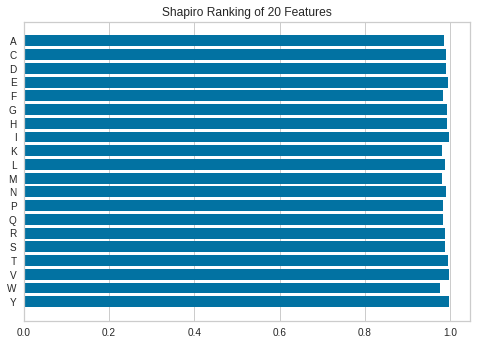

In [13]:
from yellowbrick.features import rank1d
rank1d(df_aac.to_numpy(), np.where(df_labels.labels == "Sugar transport", 1, 0), features = df_aac.columns)
plt.show()

### Independent test set

In [14]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
    feature_names,
) = get_independent_test_set(df_aac, df_labels, test_size=0.2)

### Preprocessing

In [15]:
# preprocess = make_pipeline(StandardScaler())
# X_train_processed = preprocess.fit_transform(X_train)

### Model selection

SVC (with default RBF kernel) and linear SVM look the most promising. I will choose RBF and switch to linear if the model is overfitting.

In [16]:
for estimator in [
    LinearSVC(random_state=0),
    LinearSVC(class_weight="balanced", random_state=0),
    SVC(),
    SVC(class_weight="balanced"),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=0),
    RandomForestClassifier(class_weight="balanced", random_state=0),
    SGDClassifier(random_state=0),
]:
    pipeline = make_pipeline(StandardScaler(), estimator)
    scores = cross_val_score(estimator, X_train, y_train, scoring="f1_macro")
    print("### ", estimator)
    print(f"CV folds: {scores.round(3)}")
    print(f"Mean: {scores.mean().round(3)}")
    print(f"Std: {scores.std().round(3)}")


###  LinearSVC(random_state=0)
CV folds: [0.522 0.564 0.545 0.518 0.613]
Mean: 0.552
Std: 0.035
###  LinearSVC(class_weight='balanced', random_state=0)
CV folds: [0.639 0.677 0.654 0.636 0.616]
Mean: 0.644
Std: 0.02
###  SVC()
CV folds: [0.783 0.73  0.709 0.8   0.704]
Mean: 0.745
Std: 0.039
###  SVC(class_weight='balanced')
CV folds: [0.75  0.75  0.727 0.745 0.67 ]
Mean: 0.729
Std: 0.03
###  GaussianNB()
CV folds: [0.642 0.75  0.633 0.743 0.672]
Mean: 0.688
Std: 0.049
###  KNeighborsClassifier()
CV folds: [0.857 0.75  0.708 0.709 0.763]
Mean: 0.757
Std: 0.054
###  RandomForestClassifier(random_state=0)
CV folds: [0.768 0.893 0.726 0.778 0.738]
Mean: 0.781
Std: 0.059
###  RandomForestClassifier(class_weight='balanced', random_state=0)
CV folds: [0.768 0.875 0.764 0.776 0.778]
Mean: 0.792
Std: 0.042
###  SGDClassifier(random_state=0)
CV folds: [0.325 0.463 0.415 0.321 0.358]
Mean: 0.376
Std: 0.055


### Parameter tuning

In [17]:
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SVC()),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", 1e-0, 1e-1, 1e-2],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 0.1}
0.84081529597367


### Dimensionality reduction

In [18]:
df_train = pd.DataFrame(X_train, columns=feature_names, index=sample_names_train)
get_feature_stats(df_train, df_labels.loc[df_train.index])

,corr,mean,std,corr_abs,mean0,mean1,median0,median1,mediandiff
G,0.205107,0.082999,0.017884,0.205107,0.079189,0.086518,0.078740,0.090117,0.011377
I,-0.076115,0.078371,0.017334,0.076115,0.079741,0.077105,0.080899,0.075931,0.004968
P,-0.201665,0.041997,0.011032,0.201665,0.044308,0.039863,0.042155,0.038181,0.003973
K,0.179808,0.037573,0.013953,0.179808,0.034967,0.039980,0.034404,0.037732,0.003328
D,-0.133894,0.026624,0.009724,0.133894,0.027977,0.025375,0.027457,0.024218,0.003239
F,0.086589,0.063716,0.013716,0.086589,0.062482,0.064855,0.062921,0.066157,0.003236
Q,0.079208,0.026908,0.009211,0.079208,0.026150,0.027608,0.024658,0.027671,0.003013
A,-0.035084,0.087611,0.022588,0.035084,0.088434,0.086851,0.086364,0.083395,0.002969
S,-0.023454,0.077008,0.019199,0.023454,0.077476,0.076576,0.076412,0.073586,0.002826
Y,-0.098607,0.032715,0.010911,0.098607,0.033832,0.031682,0.034335,0.031691,0.002644


In [19]:
params_svc = {
    "svc__class_weight": ["balanced"],
    "svc__C": [1, 10, 100],
    "svc__gamma": ["scale", 1, 1e-1, 1e-2],
    "selectkbest__k": list(range(1, 20)),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), SelectKBest(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_.round(3))
print(
    "Removed features ",
    feature_names[~gsearch.best_estimator_["selectkbest"].get_support()],
)
best_estimator_svc_kbest = gsearch.best_estimator_


{'selectkbest__k': 19, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.815
Removed features  ['N']


In [20]:
params_svc = {
    "svc__class_weight": ["balanced", None],
    "svc__C": [0.1, 1, 10],
    # "svc__gamma": ["scale",1e-1, 1e-2, 1e-3],
    "pca__n_components": np.linspace(0.8, 0.99, 20),
}
gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), SVC()),
    param_grid=params_svc,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
    refit=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc_pca = gsearch.best_estimator_
display(
    pd.DataFrame.from_records(
        [
            feature_names,
            gsearch.best_estimator_["pca"].components_[0],
            gsearch.best_estimator_["pca"].components_[1],
            gsearch.best_estimator_["pca"].components_[2],
        ],
        index=["Feature", "Contrib. PC1", "Contrib. PC2", "Contrib. PC3"],
    )
    .T.set_index("Feature")
    .sort_values("Contrib. PC1", ascending=False)
)

pca = PCA()
pca.fit(X_train)
csum = np.cumsum(pca.explained_variance_ratio_)
print("Number of components to explain variance:", np.argmax(csum >= 0.93) + 1)


{'pca__n_components': 0.97, 'svc__C': 1, 'svc__class_weight': 'balanced'}
0.8226263142103157


,Contrib. PC1,Contrib. PC2,Contrib. PC3
Feature,,,
A,0.420751,-0.114278,-0.021387
G,0.325485,-0.060848,-0.22178
L,0.218094,0.165132,0.509959
R,0.172975,0.378212,-0.261042
P,0.151025,0.319757,-0.019905
W,0.126965,0.045955,-0.434146
M,0.116826,-0.315644,-0.026689
V,0.085049,-0.286933,0.218329
Q,0.018146,0.297182,-0.011354


Number of components to explain variance: 14


### Validation

In [21]:
best_estimator = best_estimator_svc_kbest
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.815+-0.035


,Amino,Sugar,Macro,Weighted
precision,0.703,0.788,0.745,0.748
recall,0.788,0.703,0.745,0.743
f1-score,0.743,0.743,0.743,0.743
support,33.000,37.000,70.000,70.000


,Amino,Sugar
Amino,26,7
Sugar,11,26


In [22]:
best_estimator = best_estimator_svc_pca
best_scores = cross_val_score(
    estimator=clone(best_estimator), X=X_train, y=y_train, scoring="f1_macro"
)
print(f"Train scores: {best_scores.mean().round(3)}+-{best_scores.std().round(3)}")

y_pred = best_estimator.predict(X_test)
y_true = y_test.copy()

report_df, confusion_matrix_df = print_validation_results(y_true, y_pred, labels=["Amino", "Sugar"])
display(report_df.round(3))
display(confusion_matrix_df)

Train scores: 0.823+-0.056


,Amino,Sugar,Macro,Weighted
precision,0.730,0.818,0.774,0.776
recall,0.818,0.730,0.774,0.771
f1-score,0.771,0.771,0.771,0.771
support,33.000,37.000,70.000,70.000


,Amino,Sugar
Amino,27,6
Sugar,10,27
